# KAN vs MLP Comparison: Classification Task

In [1]:
from utils import *

### 1. Load and preprocess UCI Heart Disease dataset

In [2]:
path = "Data/heart.dat"
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
                'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

df = pd.read_csv(path, sep=' ', header=None, names=column_names)
X = df.drop('target', axis=1).values
y = (df['target'] - 1).values  # Convert to 0/1

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor.to(device), y_train_tensor.to(device))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# dtype = torch.get_default_dtype()
# dataset = {}
# dataset['train_input'] = X_train_tensor.to(device)
# dataset['test_input'] = X_test_tensor.to(device)
# dataset['train_label'] = y_train_tensor.to(device)
# dataset['test_label'] = y_test_tensor.to(device)

In [36]:
class kan_model(nn.Module):
    def __init__(self,width):
        super(kan_model, self).__init__()
        self.KAN = KAN(width=width, grid=10, k=3)
        self.sig = nn.Sigmoid()
    def forward(self, x):
        output = self.KAN(x)
        output = self.sig(output)
        return output

my_kan = kan_model(width = [13,15,1]).to(device)
optimizer_kan = optim.Adam(my_kan.parameters(), lr=1e-4)

checkpoint directory created: ./model
saving model version 0.0


In [32]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_layers):
        super().__init__()
        layers = []
        last_dim = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(last_dim, h))
            layers.append(nn.ReLU())
            last_dim = h
        layers.append(nn.Linear(last_dim, 1))
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [ ]:
mlp = MLP(13, [9]).to(device)
optimizer = optim.Adam(mlp.parameters(), lr=1e-4)
loss_fun = nn.BCELoss()
num_epochs = 200

Epoch 1 accuracy: 0.4444, val_accuracy: 0.4444, loss: 0.7635, val_loss: 0.7671
Epoch 11 accuracy: 0.6389, val_accuracy: 0.5741, loss: 0.6451, val_loss: 0.6605
Epoch 21 accuracy: 0.7824, val_accuracy: 0.7222, loss: 0.5393, val_loss: 0.5613
Epoch 31 accuracy: 0.8287, val_accuracy: 0.7778, loss: 0.4444, val_loss: 0.4810
Epoch 41 accuracy: 0.8472, val_accuracy: 0.8148, loss: 0.3818, val_loss: 0.4431
Epoch 51 accuracy: 0.8611, val_accuracy: 0.8333, loss: 0.3446, val_loss: 0.4316
Epoch 61 accuracy: 0.8704, val_accuracy: 0.8333, loss: 0.3211, val_loss: 0.4297
Epoch 71 accuracy: 0.8750, val_accuracy: 0.8333, loss: 0.3044, val_loss: 0.4321
Epoch 81 accuracy: 0.8796, val_accuracy: 0.8333, loss: 0.2922, val_loss: 0.4396
Epoch 91 accuracy: 0.8796, val_accuracy: 0.8519, loss: 0.2828, val_loss: 0.4479
Epoch 101 accuracy: 0.8704, val_accuracy: 0.8519, loss: 0.2753, val_loss: 0.4570
Epoch 111 accuracy: 0.8750, val_accuracy: 0.8519, loss: 0.2688, val_loss: 0.4641
Epoch 121 accuracy: 0.8796, val_accurac

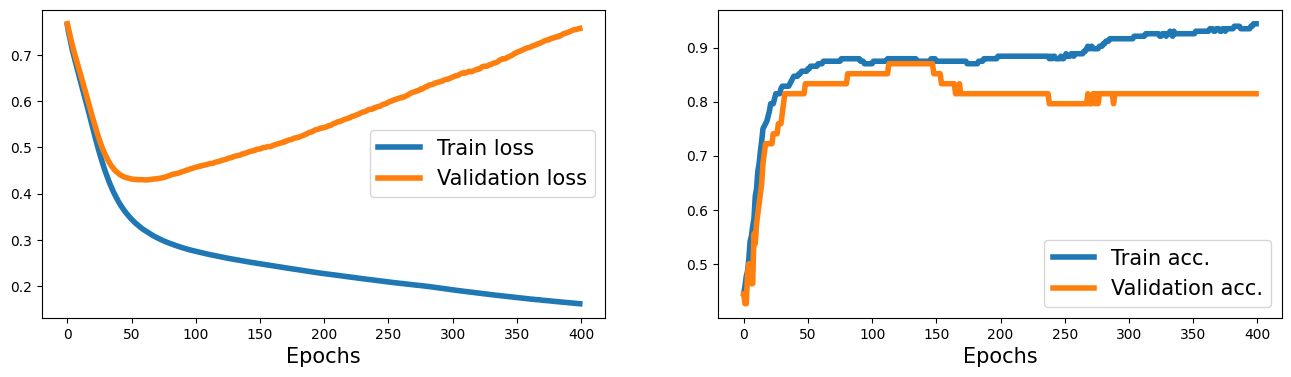

In [34]:
history_mlp = train_calssification(mlp, 400, train_loader, X_test_tensor, y_test_tensor,loss_fun,optimizer)

Epoch 1 accuracy: 0.3148, val_accuracy: 0.2963, loss: 0.7070, val_loss: 0.7061
Epoch 11 accuracy: 0.4954, val_accuracy: 0.5185, loss: 0.6933, val_loss: 0.6933
Epoch 21 accuracy: 0.6991, val_accuracy: 0.6296, loss: 0.6802, val_loss: 0.6810
Epoch 31 accuracy: 0.7731, val_accuracy: 0.7778, loss: 0.6670, val_loss: 0.6685
Epoch 41 accuracy: 0.8287, val_accuracy: 0.8148, loss: 0.6534, val_loss: 0.6558
Epoch 51 accuracy: 0.8519, val_accuracy: 0.8148, loss: 0.6389, val_loss: 0.6425
Epoch 61 accuracy: 0.8750, val_accuracy: 0.8333, loss: 0.6232, val_loss: 0.6283
Epoch 71 accuracy: 0.8750, val_accuracy: 0.8333, loss: 0.6064, val_loss: 0.6134
Epoch 81 accuracy: 0.8750, val_accuracy: 0.8333, loss: 0.5884, val_loss: 0.5975
Epoch 91 accuracy: 0.8750, val_accuracy: 0.8148, loss: 0.5694, val_loss: 0.5812
Epoch 101 accuracy: 0.8750, val_accuracy: 0.8148, loss: 0.5500, val_loss: 0.5644
Epoch 111 accuracy: 0.8750, val_accuracy: 0.8148, loss: 0.5302, val_loss: 0.5479
Epoch 121 accuracy: 0.8750, val_accurac

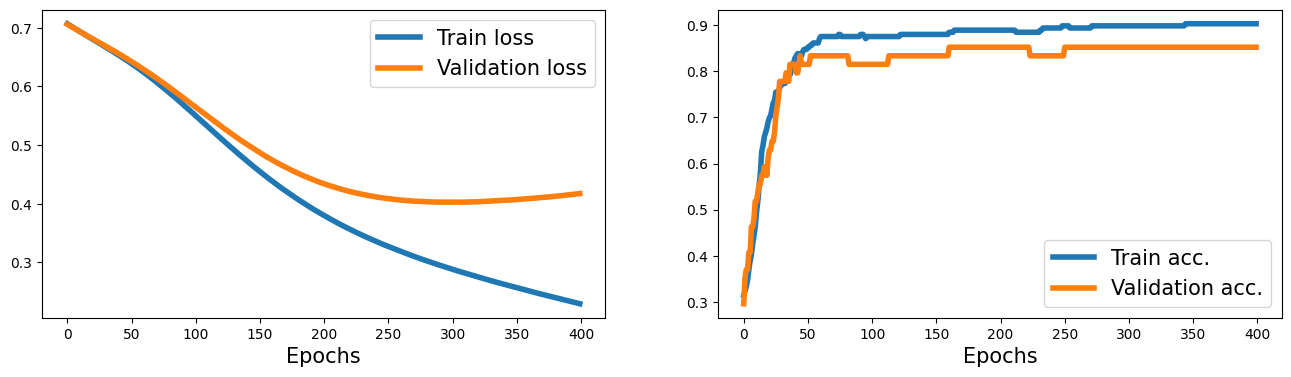

In [37]:
history_kan = train_calssification(my_kan, 400, train_loader, X_test_tensor, y_test_tensor,loss_fun,optimizer_kan)

In [8]:
# For MLP:
mlp_param_count = count_trainable_params(mlp)
print(f"MLP trainable parameters: {mlp_param_count}")

# For KAN:
kan_param_count = count_trainable_params(my_kan)
print(f"KAN trainable parameters: {kan_param_count}")

MLP trainable parameters: 136
KAN trainable parameters: 182


In [9]:
mlp.eval()
with torch.no_grad():
    mlp_pred = ((mlp(X_test_tensor.to(device)).detach().cpu())>=0.5).float()
    kan_pred = ((my_kan(X_test_tensor.to(device)).detach().cpu())>=0.5).float()

In [11]:
# Compute metrics
kan_metrics = compute_metrics(y_test_tensor, kan_pred)
mlp_metrics = compute_metrics(y_test_tensor, mlp_pred)
mlp_metrics

{'ACC': 0.8518518518518519,
 'Prec': 0.7857142857142857,
 'Rec': 0.9166666666666666,
 'F1': 0.8461538461538461,
 'AUC': np.float64(0.8583333333333333)}

In [12]:
kan_metrics

{'ACC': 0.8333333333333334,
 'Prec': 0.7777777777777778,
 'Rec': 0.875,
 'F1': 0.8235294117647058,
 'AUC': np.float64(0.8375)}